In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [3]:
BATCHSIZE = 64
EPOCH = 10
LATENT_DIM = 100
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 10000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

In [4]:
ner_df = pd.read_csv('/content/drive/My Drive/datasets/ner_dataset.csv', engine='python', na_values='NaN')

In [5]:
ner_df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
sentences_words = []
sentences_tags = []
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values: 
    if pd.notna(sent_num) and current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            current_sentence_words = []
            current_sentence_tags = []
    current_sentence_words.append(word)
    current_sentence_tags.append(tag)

In [7]:
vocab = set(itertools.chain.from_iterable(s for s in sentences_words)) 
tags = set(itertools.chain.from_iterable(s for s in sentences_tags))
sentenecs_lens = list(map(len, sentences_words))

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
words_tokenizer = Tokenizer(num_words=MAX_WORD_NUM)
words_tokenizer.fit_on_texts(sentences_words)
word_index = words_tokenizer.word_index
max_in_len = max(len(s) for s in sentences_words)
print(f"Number of input tokens: {len(word_index)}")
print(f"Maximum input sequence length: {max_in_len}")

Number of input tokens: 31811
Maximum input sequence length: 104


In [10]:
words_seq = words_tokenizer.texts_to_sequences(sentences_words)

In [11]:
words_seq_pad = pad_sequences(words_seq, maxlen=max_in_len)

In [12]:
tags_tokenizer = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tags_tokenizer.fit_on_texts(sentences_tags)
tag_index = tags_tokenizer.word_index
max_out_len = max(len(s) for s in sentences_tags)
out_word_num = len(tag_index) + 1
print(f"Number of output tokens: {len(tag_index)}")
print("Maximum output sequence length: {}".format(max_out_len))

Number of output tokens: 17
Maximum output sequence length: 104


In [13]:
tags_seq = tags_tokenizer.texts_to_sequences(sentences_tags)

In [14]:
tags_seq_pad = pad_sequences(tags_seq, maxlen=max_out_len)

In [15]:
wordVec = {}
print('Loading wordVec')
with open('/content/drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec
print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [16]:
wordNum = min(MAX_WORD_NUM, len(word_index) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

for tok, idx in word_index.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [17]:
man_target_one_hot = np.zeros((len(sentences_words), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(tags_seq_pad):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

In [18]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda, TimeDistributed
import keras.backend as K
from keras.models import Model

In [19]:
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

encoder_inputs = Input(shape=(max_in_len, ), dtype='int32',)
encoder_embedding = embedding(encoder_inputs)
encoder_LSTM = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(max_out_len, ), dtype='int32',)
decoder_embedding = embedding(decoder_inputs)
decoder_LSTM = LSTM(LATENT_DIM_DECODER, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

outputs = TimeDistributed(Dense(18, activation='softmax'))(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)

In [20]:
def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32')
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[acc])
history = model.fit([words_seq_pad, tags_seq_pad],
               man_target_one_hot,
              batch_size=BATCHSIZE, 
          epochs=EPOCH)


Epoch 1/10
750/750 [==============================] - 209s 274ms/step - loss: 0.0634 - acc: 0.9361
Epoch 2/10
750/750 [==============================] - 208s 277ms/step - loss: 3.5530e-04 - acc: 0.9999
Epoch 3/10
750/750 [==============================] - 207s 275ms/step - loss: 8.3599e-05 - acc: 1.0000
Epoch 4/10
750/750 [==============================] - 206s 275ms/step - loss: 3.4129e-05 - acc: 1.0000
Epoch 5/10
750/750 [==============================] - 206s 274ms/step - loss: 1.7633e-05 - acc: 1.0000
Epoch 6/10
750/750 [==============================] - 204s 272ms/step - loss: 1.0511e-05 - acc: 1.0000
Epoch 7/10
750/750 [==============================] - 206s 275ms/step - loss: 6.4909e-06 - acc: 1.0000
Epoch 8/10
750/750 [==============================] - 206s 275ms/step - loss: 4.1127e-06 - acc: 1.0000
Epoch 9/10
750/750 [==============================] - 207s 276ms/step - loss: 2.6778e-06 - acc: 1.0000
Epoch 10/10
750/750 [==============================] - 207s 276ms/step - loss

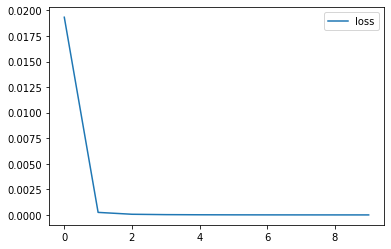

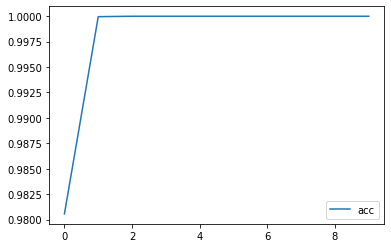

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.legend()
plt.show()